Code copied from knn_lacounty_wholedataset
Trying to fix the categorical variables with getdummies() but how many columns is too many?


In [2]:
import numpy as np
import pandas as pd
import psycopg2
from psycopg2.extras import execute_values
import matplotlib.pyplot as plt

In [6]:
# Change these variables to suit local database and associated Postgresql username and password 
host_name = 'localhost'
db_name = 'parcelDatabase'
username =  'postgres'
pw = 'correcthorsebatteryalien'
tablename = 'parceltable'


In [7]:
# Connect to local database
try:
        conn = psycopg2.connect(host = host_name, database=db_name, port = 5432, user=username, password=pw)
        print("successfully connected to database")
except:
        print("I am unable to connect to the database")

successfully connected to database


In [8]:
# Create dataframe
df = pd.read_sql_query('select * from ' + tablename, con=conn)
df = df.drop(['usecodedescchar1', 'usecodedescchar2', 'istaxableparcel'], 1)

In [9]:
# copied from Anna + Yury's SVR_vs_other_models.py
# method to turn all characters from usecode to numbers instead of letters 
lettersToNumbers = {"A": 10, "B": 11, "C": 12, "D": 13, "E": 14, "F": 15, "G": 16,
                    "H": 17, "I": 18, "J": 19, "K": 20, "L": 21, "M": 22, "N": 23,
                    "O": 24, "P": 25, "Q": 26, "R": 27, "S": 28, "T": 29, "U": 30,
                    "V": 31, "W": 32, "X": 33, "Y": 34, "Z": 35, " ": -1}
def encode(col):
    for x in lettersToNumbers:
        df[col] = df[col].replace(x,lettersToNumbers[x])
        
# create a new column for each use code character
df['usecode1'] = df['usecode'].astype(str).str[0]
df['usecode2'] = df['usecode'].astype(str).str[1]
df['usecode3'] = df['usecode'].astype(str).str[2]
df['usecode4'] = df['usecode'].astype(str).str[3]

# turn all letters in these new columns into numbers
encode('usecode1')
encode('usecode2')
encode('usecode3')
encode('usecode4')

# turn new cols into numeric values instead of string values
usecode_cols = ['usecode1', 'usecode2', 'usecode3', 'usecode4']
df[usecode_cols] = df[usecode_cols].apply(pd.to_numeric)

# drop use code column since it is now represented by other cols
df = df.drop(['usecode'],1)

In [10]:
# Preliminary cleaning
for col in df:
    # Removes any row where column value is ''
    df = df[df[col]!= ''] 
    
    # Change data type to int and float
    if col == 'roll_landbaseyear':
        df[col] = df[col].astype(int)
    else:
        df[col] = df[col].astype(float)

# Add land value per square foot to dataframe
df['landvaluepersqft'] = df['roll_landvalue']/df['sqftmain']
df

,ain,taxratearea,yearbuilt,effectiveyearbuilt,sqftmain,roll_landvalue,roll_landbaseyear,cluster,situszip5,center_lat,center_lon,usecode1,usecode2,usecode3,usecode4,landvaluepersqft
1,5.405001e+09,13.0,0.0,0.0,0.0,805385.0,2014,4422.0,90026.0,34.075431,-118.255099,2.0,0.0,0.0,31.0,inf
11,8.556021e+09,2152.0,0.0,0.0,0.0,403012.0,2010,27625.0,91706.0,34.067557,-117.985704,1.0,0.0,0.0,31.0,inf
12,6.047017e+09,1208.0,0.0,0.0,0.0,88209.0,2002,25624.0,90044.0,33.954734,-118.299990,1.0,0.0,0.0,31.0,inf
15,5.454027e+09,4.0,1994.0,1994.0,779.0,65955.0,1987,27680.0,90065.0,34.095796,-118.228163,1.0,1.0,0.0,0.0,84.666239
20,7.416025e+09,400.0,0.0,0.0,0.0,141353.0,1990,26630.0,90744.0,33.779957,-118.268222,1.0,0.0,0.0,31.0,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40081,6.271036e+09,11274.0,1940.0,1959.0,1208.0,173000.0,2011,26613.0,90706.0,33.895317,-118.125651,1.0,7.0,2.0,0.0,143.211921
40082,2.830001e+09,405.0,1969.0,1969.0,6720.0,649355.0,2012,24627.0,91321.0,34.378673,-118.547262,1.0,7.0,0.0,0.0,96.630208
40083,6.358005e+09,6489.0,1974.0,1974.0,2120.0,650869.0,2005,26619.0,90201.0,33.969522,-118.148882,2.0,1.0,1.0,0.0,307.013679
40084,5.682018e+09,4.0,1991.0,1991.0,12666.0,249582.0,2002,27680.0,90041.0,34.140756,-118.219785,1.0,2.0,0.0,0.0,19.704879


In [11]:
# Clean data
df= df[df['sqftmain'] != 0]
df= df[df['landvaluepersqft'] < 1000]
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
df

,ain,taxratearea,yearbuilt,effectiveyearbuilt,sqftmain,roll_landvalue,roll_landbaseyear,cluster,situszip5,center_lat,center_lon,usecode1,usecode2,usecode3,usecode4,landvaluepersqft
15,5.454027e+09,4.0,1994.0,1994.0,779.0,65955.0,1987,27680.0,90065.0,34.095796,-118.228163,1.0,1.0,0.0,0.0,84.666239
21,6.052030e+09,461.0,1964.0,1964.0,1000.0,8339.0,1975,26631.0,90003.0,33.947870,-118.265508,1.0,1.0,0.0,0.0,8.339000
24,4.231020e+09,12463.0,0.0,1955.0,1250.0,50626.0,1975,25691.0,90066.0,33.996590,-118.429746,1.0,1.0,0.0,0.0,40.500800
34,5.359005e+09,1797.0,1961.0,1961.0,612.0,61899.0,1975,27630.0,91801.0,34.078510,-118.118021,1.0,1.0,0.0,0.0,101.142157
38,4.231018e+09,67.0,1949.0,1949.0,621.0,31585.0,1975,25691.0,90066.0,33.996502,-118.428373,1.0,1.0,0.0,0.0,50.861514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40081,6.271036e+09,11274.0,1940.0,1959.0,1208.0,173000.0,2011,26613.0,90706.0,33.895317,-118.125651,1.0,7.0,2.0,0.0,143.211921
40082,2.830001e+09,405.0,1969.0,1969.0,6720.0,649355.0,2012,24627.0,91321.0,34.378673,-118.547262,1.0,7.0,0.0,0.0,96.630208
40083,6.358005e+09,6489.0,1974.0,1974.0,2120.0,650869.0,2005,26619.0,90201.0,33.969522,-118.148882,2.0,1.0,1.0,0.0,307.013679
40084,5.682018e+09,4.0,1991.0,1991.0,12666.0,249582.0,2002,27680.0,90041.0,34.140756,-118.219785,1.0,2.0,0.0,0.0,19.704879


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [13]:
# Set dependent and independent variables
X = pd.DataFrame(df[['roll_landbaseyear','center_lat', 'center_lon', 'taxratearea', 'yearbuilt', 'effectiveyearbuilt', 'cluster', 'situszip5', 'usecode1', 'usecode2', 'usecode3', 'usecode4']])
y = pd.DataFrame(df['landvaluepersqft']) 

In [14]:
# Split data randomly - 30% used for test data; 70% used for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# Create kNN Model
knn= KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=10)

In [16]:
# Create predictions for test data
y_pred = knn.predict(X_test)

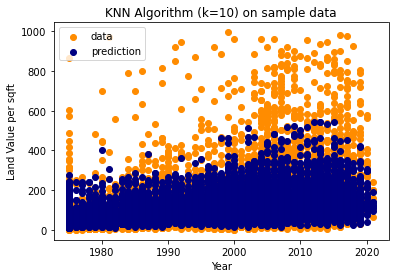

In [17]:
# Evaluate model
plt.scatter(X_test['roll_landbaseyear'], y_test, color="darkorange", label="data")
plt.scatter(X_test['roll_landbaseyear'], y_pred, color="navy", label="prediction")
plt.legend()
plt.xlabel('Year')
plt.ylabel('Land Value per sqft')
plt.title("KNN Algorithm (k=10) on sample data")
plt.show()

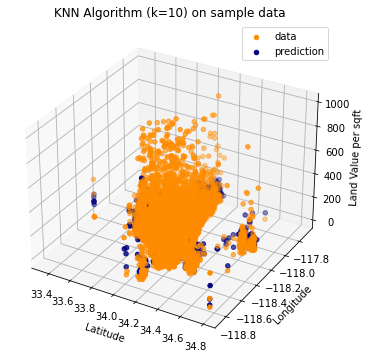

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_test['center_lat'], X_test['center_lon'], y_test, color="darkorange", label="data")
ax.scatter3D(X_test['center_lat'], X_test['center_lon'], y_pred, color="navy", label="prediction")
ax.legend()
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Land Value per sqft')
plt.title("KNN Algorithm (k=10) on sample data")
plt.show()

In [19]:
error = sqrt(mean_squared_error(y_test,y_pred))
error

122.1551173727585

In [20]:
# Create a dataframe that contains all columns, but only rows where landbaseyear is 2021
df_assess = df.copy()
df_assess = df_assess[df_assess['roll_landbaseyear'] == 2021]
df_assess

,ain,taxratearea,yearbuilt,effectiveyearbuilt,sqftmain,roll_landvalue,roll_landbaseyear,cluster,situszip5,center_lat,center_lon,usecode1,usecode2,usecode3,usecode4,landvaluepersqft
410,6.010013e+09,1166.0,1938.0,1947.0,1300.0,180000.0,2021,26604.0,90001.0,33.976127,-118.256092,1.0,1.0,0.0,0.0,138.461538
1972,7.126034e+09,4992.0,1918.0,1950.0,2211.0,300000.0,2021,26625.0,90805.0,33.854559,-118.190454,1.0,2.0,1.0,0.0,135.685210
4496,5.073028e+09,401.0,1923.0,1937.0,10010.0,2000000.0,2021,25693.0,90018.0,34.039579,-118.315336,1.0,2.0,1.0,0.0,199.800200
7132,7.355001e+09,9340.0,1945.0,1960.0,1800.0,460000.0,2021,26683.0,90501.0,33.835648,-118.328291,1.0,7.0,0.0,0.0,255.555556
9987,7.257016e+09,5500.0,1961.0,1962.0,6396.0,2000000.0,2021,26614.0,90803.0,33.771413,-118.150569,1.0,7.0,0.0,0.0,312.695435
10749,3.242015e+09,1858.0,1947.0,1947.0,1855.0,80000.0,2021,24606.0,93532.0,34.678218,-118.451900,1.0,2.0,1.0,0.0,43.126685
11612,2.632006e+09,13.0,1974.0,1975.0,152076.0,12715000.0,2021,24630.0,91352.0,34.223669,-118.377940,1.0,3.0,2.0,0.0,83.609511
11898,8.383010e+09,12296.0,1988.0,1990.0,95976.0,8850000.0,2021,23671.0,91773.0,34.109284,-117.824483,1.0,7.0,0.0,2.0,92.210553
12887,4.139005e+09,3710.0,2010.0,2010.0,2080.0,1000000.0,2021,26681.0,90245.0,33.918572,-118.401891,1.0,7.0,0.0,12.0,480.769231
15333,4.446003e+09,1653.0,1936.0,1948.0,1561.0,1000000.0,2021,25698.0,90290.0,34.083735,-118.599532,1.0,2.0,1.0,0.0,640.614990


In [21]:
# Make predictions for the land value per squarefoot for the properties that were assessed in 2021 (y_assess_pred), 
# and compare them to the actual values (y_assess)
X_assess = pd.DataFrame(df_assess[['roll_landbaseyear','center_lat', 'center_lon', 'taxratearea', 'yearbuilt', 'effectiveyearbuilt', 'cluster', 'situszip5', 'usecode1', 'usecode2', 'usecode3', 'usecode4']])
y_assess = pd.DataFrame(df_assess['landvaluepersqft'])
y_assess_pred = knn.predict(X_assess)

In [22]:
print("For properties assessed in 2021")
print("Mean predicted LV/sqft: ", y_assess_pred.mean())
print("Mean actual LV/sqft: ", y_assess['landvaluepersqft'].mean())
print("St. Dev of predicted LV/sqft: ", y_assess_pred.std())
print("St. Dev of actual LV/sqft: ", y_assess['landvaluepersqft'].std())
print("Mean error: ", sqrt(mean_squared_error(y_assess,y_assess_pred)))

For properties assessed in 2021
Mean predicted LV/sqft:  155.36095012768823
Mean actual LV/sqft:  228.62254697365842
St. Dev of predicted LV/sqft:  69.9004023321379
St. Dev of actual LV/sqft:  163.84551936980918
Mean error:  143.12293532521988


In [23]:
# Create a copy of X, but with all landbaseyear values replaced with 2021
X_current = X.copy()
X_current["roll_landbaseyear"] = 2021
X_current

,roll_landbaseyear,center_lat,center_lon,taxratearea,yearbuilt,effectiveyearbuilt,cluster,situszip5,usecode1,usecode2,usecode3,usecode4
15,2021,34.095796,-118.228163,4.0,1994.0,1994.0,27680.0,90065.0,1.0,1.0,0.0,0.0
21,2021,33.947870,-118.265508,461.0,1964.0,1964.0,26631.0,90003.0,1.0,1.0,0.0,0.0
24,2021,33.996590,-118.429746,12463.0,0.0,1955.0,25691.0,90066.0,1.0,1.0,0.0,0.0
34,2021,34.078510,-118.118021,1797.0,1961.0,1961.0,27630.0,91801.0,1.0,1.0,0.0,0.0
38,2021,33.996502,-118.428373,67.0,1949.0,1949.0,25691.0,90066.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
40081,2021,33.895317,-118.125651,11274.0,1940.0,1959.0,26613.0,90706.0,1.0,7.0,2.0,0.0
40082,2021,34.378673,-118.547262,405.0,1969.0,1969.0,24627.0,91321.0,1.0,7.0,0.0,0.0
40083,2021,33.969522,-118.148882,6489.0,1974.0,1974.0,26619.0,90201.0,2.0,1.0,1.0,0.0
40084,2021,34.140756,-118.219785,4.0,1991.0,1991.0,27680.0,90041.0,1.0,2.0,0.0,0.0


In [24]:
# Predict land value for each property if it were assessed in 2021 based on latitude and longitude
y_current = knn.predict(X_current)

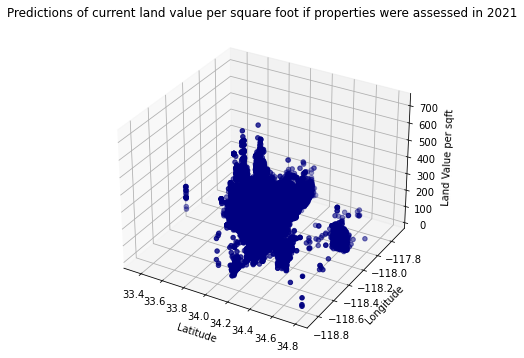

In [25]:
# Plot the predictions for land value per sqft if properties were assessed in 2021
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_current['center_lat'], X_current['center_lon'], y_current, color="navy")
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Land Value per sqft')
plt.title("Predictions of current land value per square foot if properties were assessed in 2021")
plt.show()